<a href="https://colab.research.google.com/github/voke-brume/AI-ML/blob/main/ML/vokeBrumeCPE620Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CPE 620: DEEP LEARNING**
**Assignment 02**

Voke Brume

**U-NET ARCHITECTURE FOR DENOISING MNIST DATASET**

## **INTRODUCTION**

### **PAPER**

#### **U-Net: Convolutional Networks for Biomedical Image Segmentation**

Deep convolutional networks are currently the best in visual recognition tasks, outperforming state-of-the-art methods and models. While this is true, a considerable disadvantage has always been the size of training sets needed to train such models properly. The issue of small-sized training sets is even more of a problem with biomedical tasks where available training sets are minimal. This is why the sliding window setup was proposed by Ciresan et al., where the trained network is used to predict the class label of each pixel by providing a local region around a pixel as input instead of using the entire image. The benefits of Ciresan et al. include better localization and access to much larger training images. At the same time, the drawbacks are its slow performance and the trade-off between localization accuracy and the use of context.

U-Net is a more elegant architecture designed by modifying and extending a fully convolutional network such that it works with very few training images and yields more precise segmentations. The u-Net architecture consists of a left-side contracting path (like most architectures) and a right-side expansive path. "The main idea is to supplement a usual contrasting network by successive layers, where pooling operators are replaced by upsampling operators" (Ronneberger et al.). This process helps to increase the resolution of the output. To improve localization, high-resolution features from the left side (represented as white boxes) are combined with the upsampled output to produce the right side.

### **IMPORTS**

In [ ]:
# Import required libraries
import numpy as np
import tensorflow as tf

from skimage import transform
from keras import Model
from keras.datasets import mnist
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from matplotlib import pyplot as plt

### **FUNCTIONS**

In [ ]:
# FUNCTIONS


# Function to resize mnist from 28x28 to 32x32   
# @param: batch_images
# @return: resized_batch_images
def resize_batch(batch_images):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    batch_images = batch_images.reshape((-1, 28, 28, 1))
    resized_batch_images = np.zeros((batch_images.shape[0], 32, 32, 1))
    for i in range(batch_images.shape[0]):
        resized_batch_images[i, ..., 0] = transform.resize(batch_images[i, ..., 0], (32, 32))
    return resized_batch_images

# Function to Display specified number of images
# @param: data, number_of_images
# @return: plot
def show_images(data, number_of_images, plt_title):
    n = number_of_images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title(plt_title)
    plt.show()

# Function to Generate random zeros and ones of specific percentage
# @param: one_percentage, size
# @return: matrix
def generate_percentage_matrix(sigma, percentage, shape):
  num_replaced = int( (1-percentage/100) * (shape[0]*shape[1]) )

  # Random (x, y) coordinates
  indices_x = np.random.randint(0, shape[0], num_replaced)
  indices_y = np.random.randint(0, shape[1], num_replaced)

  # Matrix with noise values
  matrix = sigma * np.random.normal(loc=0.0, scale=1.0, size=shape)

  # Change value at random index to 0
  matrix[indices_x, indices_y] = 0

  # Return matrix
  return matrix


# Function to add percentage of gaussian noise to dataset
# @param: data, number_of_images
# @return: plot
def add_gaussian_noise(sigma, batch_data, percentage):
  return batch_data +  generate_percentage_matrix( sigma, percentage, (batch_data.shape) )

# Function to construct U-Net autoencoder
# @param: input_layer, start_neurons
# @return: output_layer
def unet(input_layer, start_neurons):
    #Encoding path
    c1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.5)(p2)

    c3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.5)(p3)

    c4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.5)(p4)

    # Middle path
    cm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(p4)
    cm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(cm)
    
    #Decoding path
    dc4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(cm)
    uc4 = concatenate([dc4, c4])
    uc4 = Dropout(0.5)(uc4)
    uc4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uc4)
    uco4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uc4)

    dc3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uc4)
    uc3 = concatenate([dc3, c3])
    uc3 = Dropout(0.5)(uc3)
    uc3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uc3)
    uc3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uc3)

    dc2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uc3)
    uc2 = concatenate([dc2, c2])
    uc2 = Dropout(0.5)(uc2)
    uc2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uc2)
    uc2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uc2)

    dc1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uc2)
    uc1 = concatenate([dc1, c1])
    uc1 = Dropout(0.5)(uc1)
    uc1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uc1)
    uc1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uc1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uc1)
    
    #Creating and compiling keras-model
    model = Model(input_layer, output_layer)
    model.compile(tf.keras.optimizers.Adam(learning_rate = .001), loss = "binary_crossentropy")

    # Print model architecture
    model.summary

    return model

# Function for predicting test image with
# specified gaussian noise
# Plots: Original Data, Test Data, Predicted Data
def test_model(model, sigma, test_data, num_images):
  # Print original data
  show_images(test_data, num_images, 'Original Image')
  # Add noise to first 10 test images
  noisy_data = test_data + sigma * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
  # Clip values between 0 and 1 to enhace image
  noisy_data = np.clip(noisy_data, 0., 1.)
  # Plot noisy image
  show_images(noisy_data, num_images, 'Noisy image with sigma = {sigma:.2f}'.format(sigma=sigma))
  # Print result of U-Net prediction
  show_images(model.predict(noisy_data), num_images, 'Predicted Image')

## **DATA**

### **MNIST DATA**

The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

The train and test bacth of the mnist data is loaded into variables. Their labels are not loaded because they are not needed for the task of denoising.

In [ ]:
# Unwrap data
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### **DATA PREPROCESSING**

The first step is to convert the loaded data values into floating numbers to improve computational performance.

In [ ]:
# Normalize images between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

The shape of the loaded data sets is then visualized to ensure data is intact and accurate

In [ ]:
# Print shape of train and test data set
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Both train and test data sets are then reshaped to fit the mode in which they will be passed into the U-net model

In [ ]:
# Reshape images for U-Net autoencoder
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

As observed above, the height and width of the images in the data sets are 28 x 28. U-Net autoencoder is 4-layers deep, but the size of the data sets can not be continuously divided 2 without a remainder, meaning matching encodeer and decoder sizes will take significant work in modifying the architecture. Therefore, the images are resized to 32 x 32 to solve this issue.

In [ ]:
# Resize images to 32x32 so they are divisible by 2
x_train = resize_batch(x_train)
x_test = resize_batch(x_test)

The shapes of the resized data sets are then printed to verify that the process was successful.

In [ ]:
# Print new shape of train and test data set
print(x_train.shape)
print(x_test.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


To understand what level of gaussian noise to add to the images, various levels are added and the results are visualized and compared to the original image.

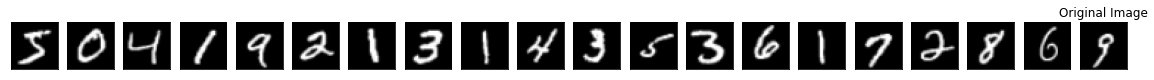

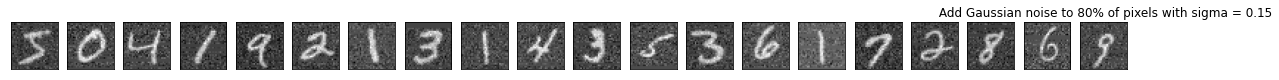

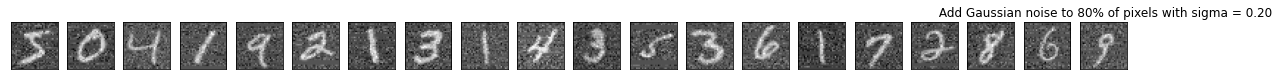

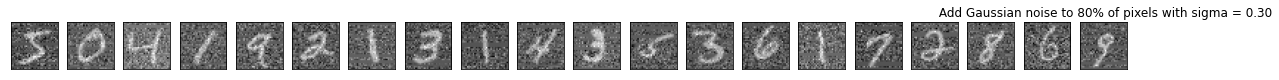

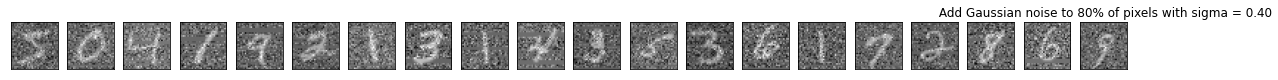

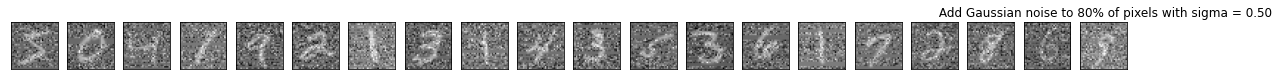

In [ ]:
# Initialize percentage of pixels to add noise (>1)
PERCENTAGE_OF_PIXELS = 80

# Initialize a list of sigma values
sigma = [0.15, 0.20, 0.30, 0.40, 0.50]

# Plot original train data 
show_images(x_train, 20, 'Original Image')

# Plot train data with increasing noise
for value in sigma:
  noisy_data = add_gaussian_noise(value, x_train, PERCENTAGE_OF_PIXELS)
  show_images(noisy_data, 20 , plt_title=' Add Gaussian noise to 80% of pixels with sigma = {sigma:.2f}'.format(sigma=value))

A sigma value of 0.50 is chosen to be used in training the model. This is chosen so the model can learn on very noisy images to better perform on a wide range of noise levels. After noise is added, the images are then enhanced by clipping the values of their pixel to either 0 and 1.

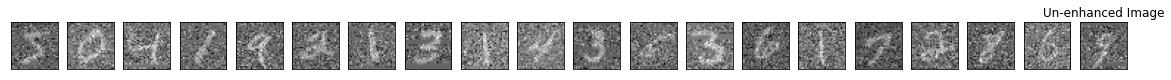

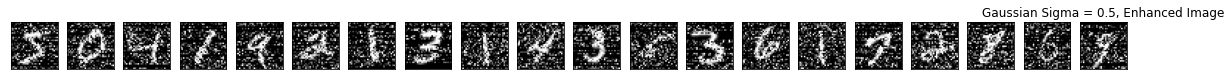

In [ ]:

# Add gaussian noise with sigma of 0.50
x_train_noisy = add_gaussian_noise(0.50, x_train, PERCENTAGE_OF_PIXELS)

# Print unenhanced images
show_images(x_train_noisy, 20, 'Un-enhanced Image')

# Enhance noisy images by clipping values between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

# Plot noisy images
show_images(x_train_noisy, 20, 'Gaussian Sigma = 0.5, Enhanced Image')

The above plot shows the enhanced images have better contrast compared to the unenhanced images, thereby making them easier for the model to detect.


## **MODEL**

A U-Net model is then created and fitted using the following hyperparameters:

- Learning Rate: 0.001
- Loss function: Binary Cross-Entropy
- Optimizer: Adam
- Epoch: 20
- Batch Size: 150
- Shuffle: True

The 60,000 train images in mnist are divided in training data of 55,000 images and validation data of 5,000.


In [ ]:
#Creating instance of UNET model, for 256x256 input and with 16 starting filters 
model = unet(tf.keras.layers.Input((32,32,1)), 16)

#Training model 100 epochs, only 2 imgs per batch bacause of GPU memory limitation
model.fit(x_train_noisy[:55000], x_train[:55000], 
          epochs = 20, 
          batch_size = 150, 
          shuffle=True,
          validation_data=(x_train_noisy[55000:], x_train[55000:]))

Epoch 1/20
367/367 [==============================] - 29s 34ms/step - loss: 0.1593 - val_loss: 0.1214
Epoch 2/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1208 - val_loss: 0.1174
Epoch 3/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1178 - val_loss: 0.1154
Epoch 4/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1159 - val_loss: 0.1140
Epoch 5/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1148 - val_loss: 0.1136
Epoch 6/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1140 - val_loss: 0.1128
Epoch 7/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1135 - val_loss: 0.1124
Epoch 8/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1131 - val_loss: 0.1121
Epoch 9/20
367/367 [==============================] - 11s 30ms/step - loss: 0.1127 - val_loss: 0.1117
Epoch 10/20
367/367 [==============================] - 11s 31ms/step - loss: 0.112

The ROC curve is plotted to visualize the train loss vs validation loss.

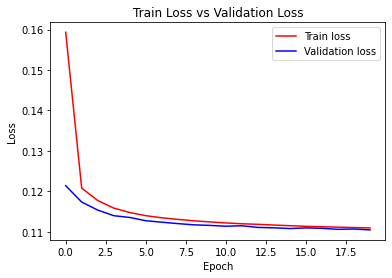

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot ROC curve

# Number of epoch
epochs = range(len(model.history.history['loss']))
# Plot
plt.plot(epochs,model.history.history['loss'],'r', label='Train loss')
plt.plot(epochs,model.history.history['val_loss'],'b', label='Validation loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()
plt.show()

## **RESULT**

The trained model is then used to denoise 10 varying noise levels on 10 different test images. The results are then ploted to observe the performance of the model.

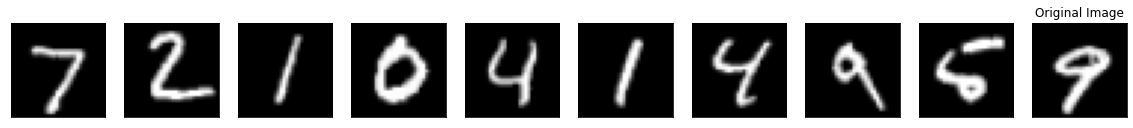

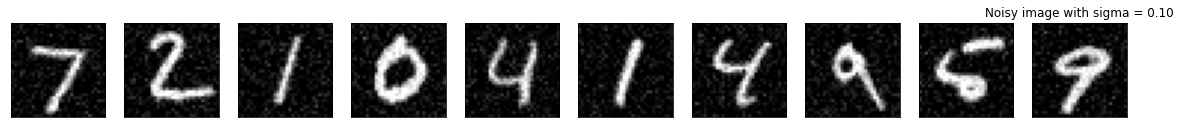

1/1 [==============================] - 1s 581ms/step


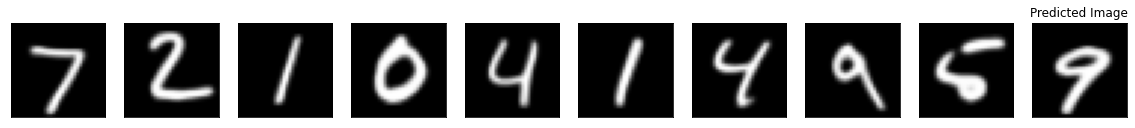

In [ ]:
# GAUSSIAN NOISE = 0.1
test_model(model, 0.1, x_test[:10], 10)

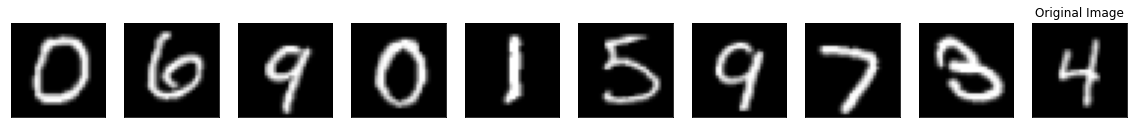

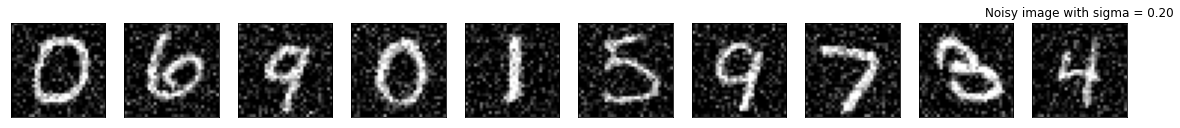

1/1 [==============================] - 0s 21ms/step


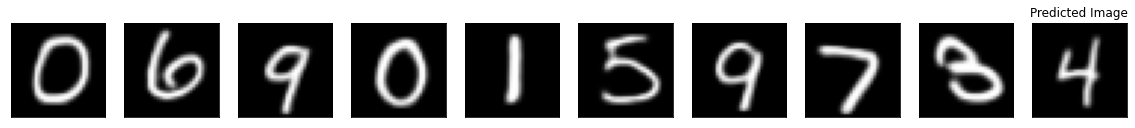

In [ ]:
# GAUSSIAN NOISE = 0.2
test_model(model, 0.2, x_test[10:20], 10)

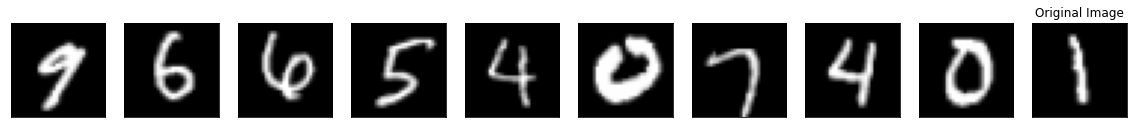

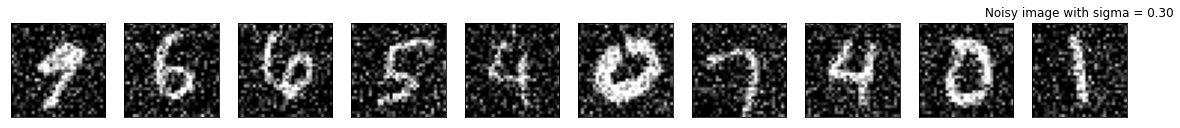

1/1 [==============================] - 0s 24ms/step


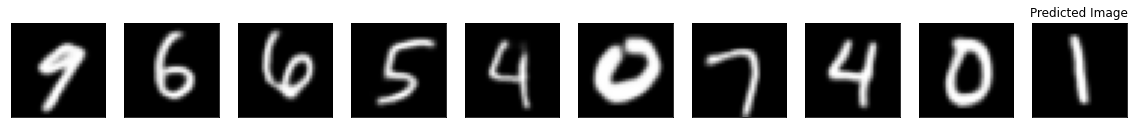

In [ ]:
# GAUSSIAN NOISE = 0.3
test_model(model, 0.3, x_test[20:30], 10)

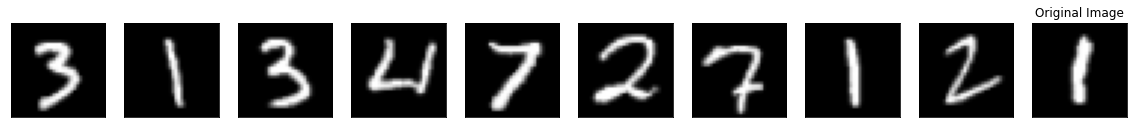

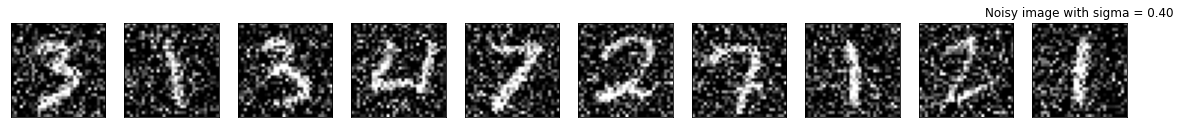

1/1 [==============================] - 0s 33ms/step


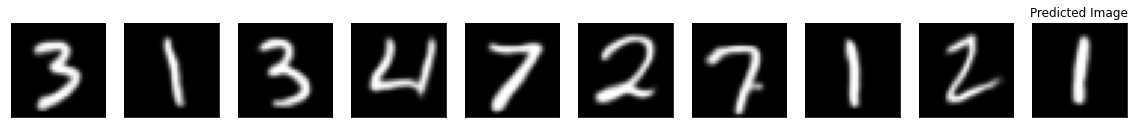

In [ ]:
# GAUSSIAN NOISE = 0.4
test_model(model, 0.4, x_test[30:40], 10)

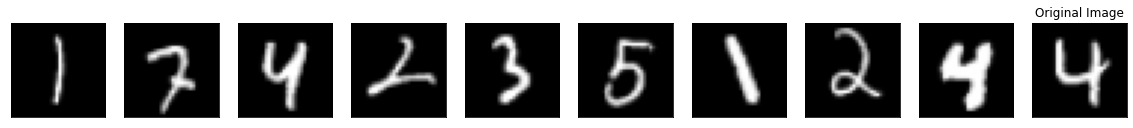

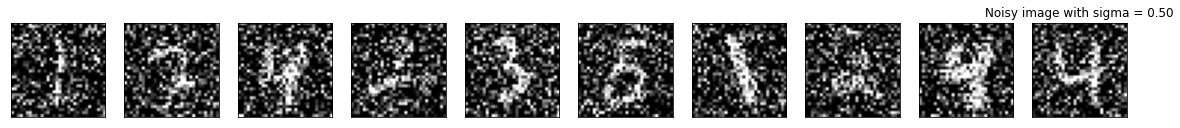

1/1 [==============================] - 0s 25ms/step


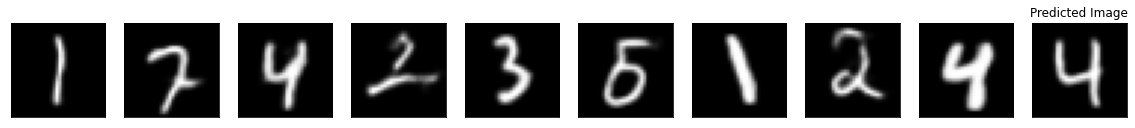

In [ ]:
# GAUSSIAN NOISE = 0.5
test_model(model, 0.5, x_test[40:50], 10)

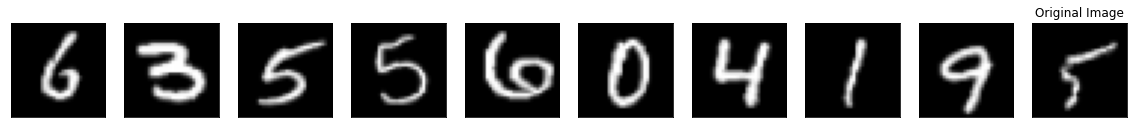

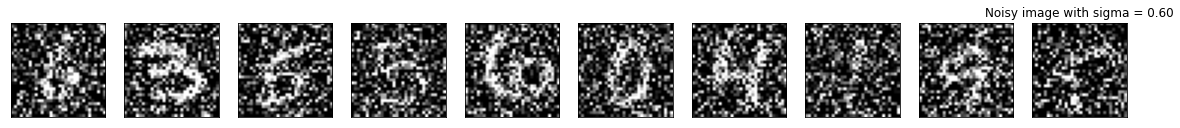

1/1 [==============================] - 0s 21ms/step


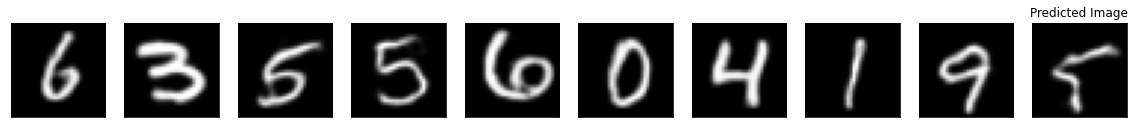

In [ ]:
# GAUSSIAN NOISE = 0.6
test_model(model, 0.6, x_test[50:60], 10)

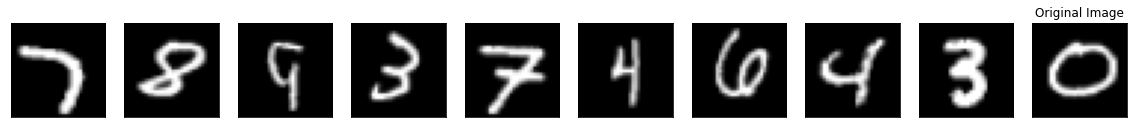

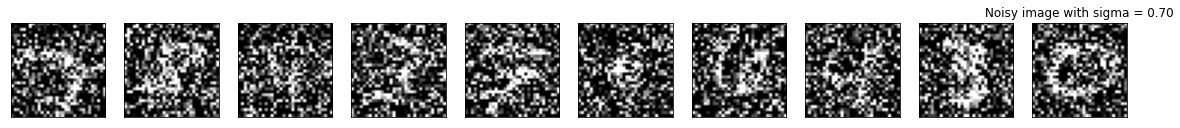

1/1 [==============================] - 0s 43ms/step


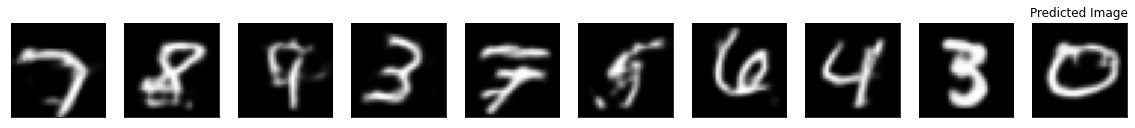

In [ ]:
# GAUSSIAN NOISE = 0.7
test_model(model, 0.7, x_test[60:70], 10)

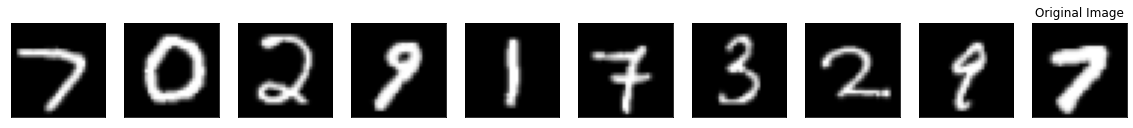

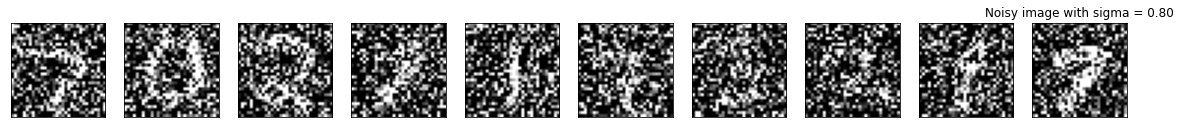

1/1 [==============================] - 0s 46ms/step


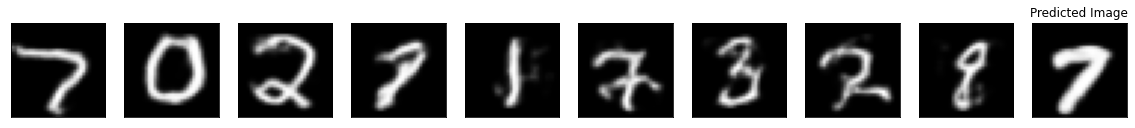

In [ ]:
# GAUSSIAN NOISE = 0.8
test_model(model, 0.8, x_test[70:80], 10)

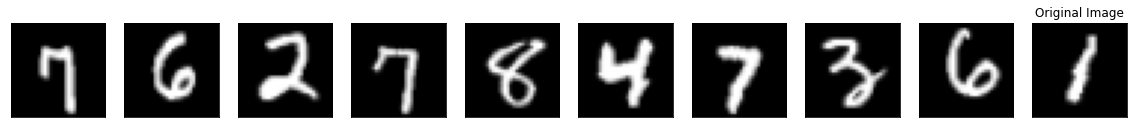

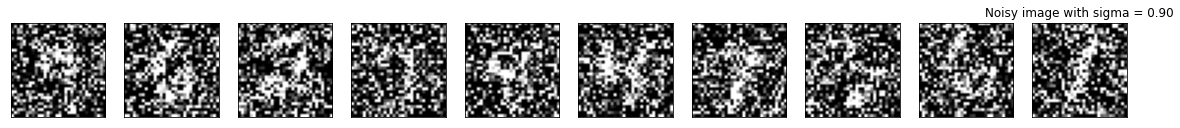

1/1 [==============================] - 0s 25ms/step


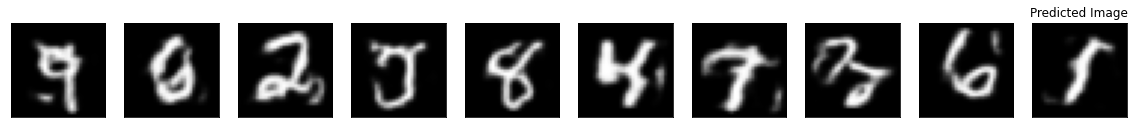

In [ ]:
# GAUSSIAN NOISE = 0.9
test_model(model, 0.9, x_test[80:90], 10)

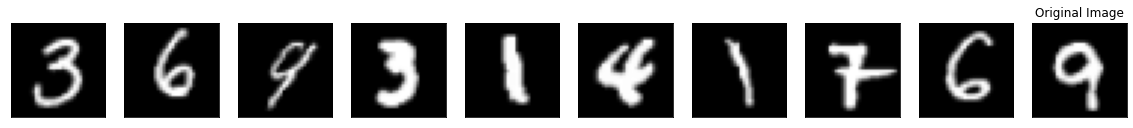

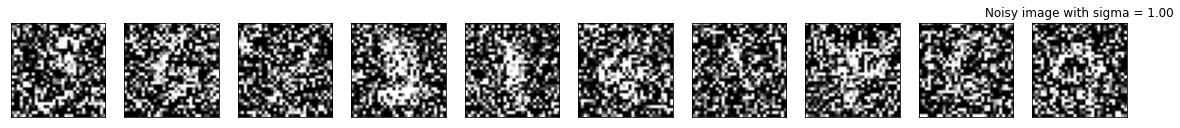

1/1 [==============================] - 0s 30ms/step


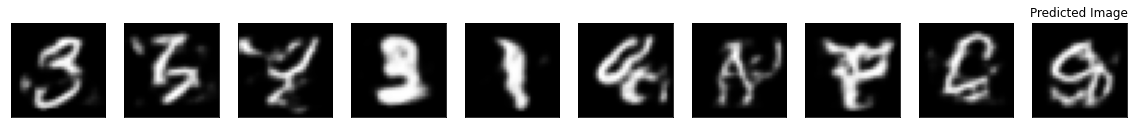

In [ ]:
# GAUSSIAN NOISE = 1.0
test_model(model, 1.0, x_test[90:100], 10)

## **ANALYSIS**

U-Net performed quite well in denoising the mnist data set. As can be observed in the above plots, U-Net was able to denoise even images that had a very high noise level (sigma=1) that makes them impossible to see by the human eye.

## **REFERENCES**

[1] Ronneberger, Fischer, and Brox., “U-net: Convolutional
Networks for Biomedical Image Segmentation”, arXiv.org, 2015

[2] Krizhevsky, A., Sutskever, I., Hinton, G.E.: “Imagenet
classification with deep convolutional neural networks”, NIPS,
2012.

[3] Ciresan, D.C., Gambardella, L.M., Giusti, A., Schmidhuber,
J., “Deep neural networks segment neuronal membranes in electron
microscopy images”, NIPS, 2012